In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import silhouette_score
import keras_tuner


2023-06-03 05:54:59.335366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/train/")
count = 0
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        for file in os.listdir(directory+folder+back+subfolder):
            file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
            if 'filtered.npy' in file_directory:
                data.append(np.load(str(file_directory)))
                count += 1

b'HIP44295-23'
b'HIP63503-523'
b'AND_XI-2274'
b'HIP36393-1253'
b'HIP48477-589'


(666733, 16, 256)


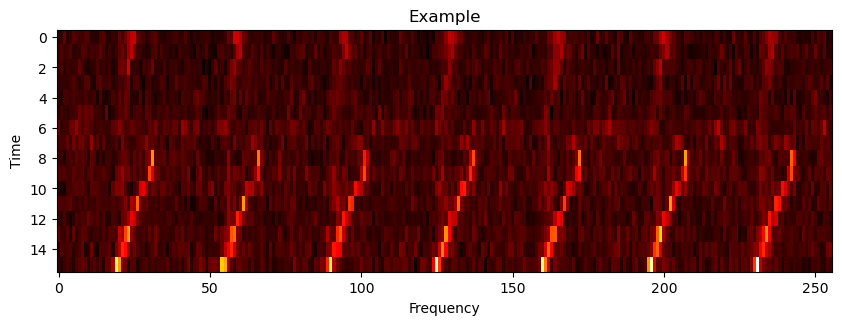

In [3]:
import numpy as np
data = np.vstack(data)
print(data.shape)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [4]:
from tqdm import tqdm

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

data = np.expand_dims(normalize_data(data), axis = -1)
print(data[0,:,:].max(), data[0,:,:].min())

100%|█████████████████████████████████| 666733/666733 [01:09<00:00, 9656.96it/s]

1.0 0.0


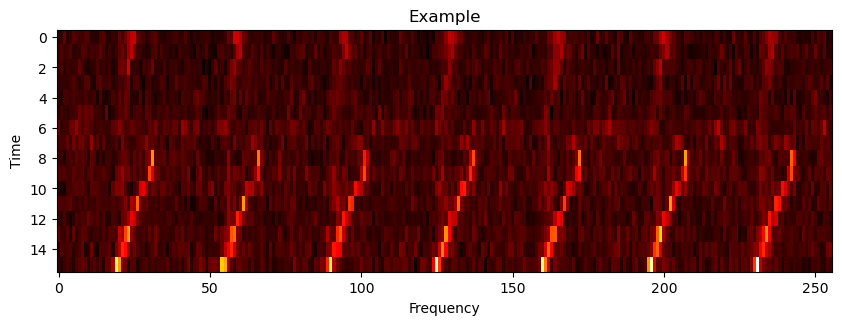

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.33, random_state=42)

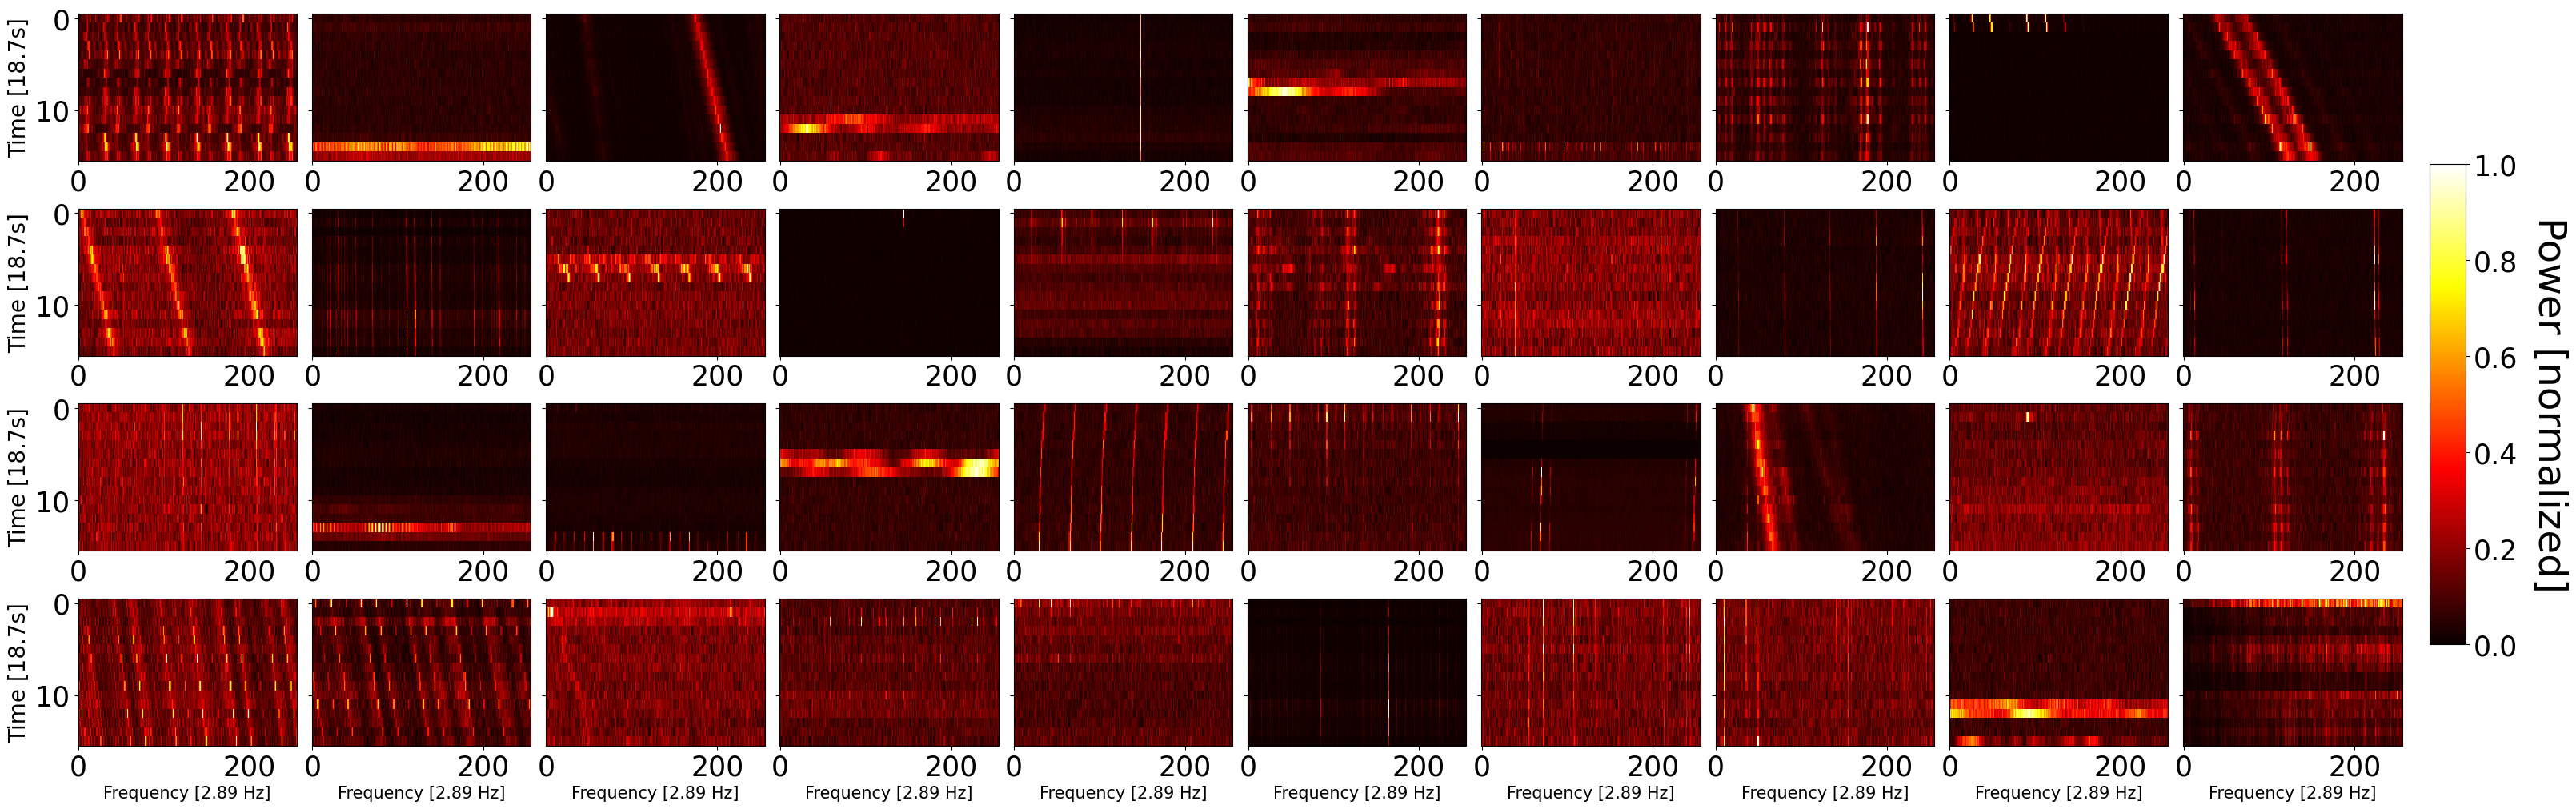

In [7]:
ind = np.random.randint(0, X_train.shape[0], size=(10, 10))
font_size = 25
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(4, 10, sharey=True, figsize=(30, 10), constrained_layout=True)

for j in range(10):
    for i in range(4):
        inde = ind[i, j]
        im = ax[i,j].imshow(X_train[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
        if i == 3:
            ax[i,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-10)  
        if j ==0:
            ax[i,j].set_ylabel("Time [18.7s]",  fontsize=font_size-5)  
                  
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/training_examples.pdf", format="pdf")


In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = 8
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(
            name="kl_loss"
        )
        self.cluster_loss_tracker = keras.metrics.Mean(
            name="clustering_loss"
        )
        self.kl_additional = tf.keras.losses.KLDivergence()
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]
    def gaussanity_loss(self, data, base):
        return self.kl_additional(data, base)
    
    def train_step(self, data_in):
        data = data_in
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            
            total_loss = reconstruction_loss + self.beta * kl_loss
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    def test_step(self, data_in):
        data, _ = data_in
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        total_loss = reconstruction_loss + self.beta * kl_loss 
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        self.cluster_loss_tracker.update_state(self.custom_score())
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "clustering_loss": self.reconstruction_loss_tracker.result()
        }
    def silhouette_score(self, X):
        center_spread = []
        for i in range(30):
            center_spread.append(tf.math.reduce_std(X[i*100:(i+1)*100]))
        intra_cluster = tf.stack(center_spread, axis=0)
        
        relative_distances = []
        for k in range(30):
            for j in range(30):
                if j != k:
                    center_1 = tf.math.reduce_mean(X[j*100:(j+1)*100], axis = 0)
                    center_2 = tf.math.reduce_mean(X[k*100:(k+1)*100], axis = 0)
                    relative_distances.append(tf.norm(center_1-center_2))
        extra_cluster = tf.stack(relative_distances, axis=0)
        
        return tf.reduce_mean(intra_cluster)/ (tf.reduce_mean(extra_cluster)+0.01)
            

    def custom_score(self):
        data = tf.convert_to_tensor(np.load("../../../../../datax/scratch/pma/reverse_search/test/clustering_tests/clustering_hyperparam_test.npy")[:3_000])
        # data = np.load("../../../../../datax/scratch/pma/reverse_search/test/clustering_hyperparam_test.npy")[:30_000]
        labels = np.load("../../../../../datax/scratch/pma/reverse_search/test/clustering_tests/clustering_hyperparam_test_labels.npy")[:3_000]
        feautres = self.encoder(data)[-1]
        
        score = self.silhouette_score(X = feautres)
        return score

# Encoder Model

In [10]:
def build_model(hp):
    latent_dim = hp.Choice("latent_dim", [3,4,5,6,7,8,10])
    cnn_kernel_1 = hp.Choice("cnn_kernel_1", [3, 8, 16, 32])
    cnn_kernel_2 = hp.Choice("cnn_kernel_2", [32, 64])
    cnn_kernel_3 = hp.Choice("cnn_kernel_3", [64, 128])
    dense_1 =  hp.Choice("dense_1", [64, 128, 256])
    dense_2 =  hp.Choice("dense_2", [32, 16, 64])
    lr = hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4])
    time_samples = X_train.shape[1]
    freq_sample =  X_train.shape[2]
    
    encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
    x = layers.Conv2D(cnn_kernel_1, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
    x = layers.MaxPool2D(pool_size=(1, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(cnn_kernel_2, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(1, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(cnn_kernel_2, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(1, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(cnn_kernel_3, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(1, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(cnn_kernel_3, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(1, 2))(x)
    x = layers.BatchNormalization()(x)
    x_shape = x.shape
    x = layers.Flatten()(x)
    x = layers.Dense(dense_1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dense_2, activation="relu")(x)
    x = layers.BatchNormalization()(x)


    z_mean = layers.Dense(dense_2, activation="relu")(x)
    z_mean = layers.BatchNormalization()(z_mean)
    z_mean = layers.Dense(latent_dim, name="z_mean")(z_mean)

    z_log_var = layers.Dense(dense_2, activation="relu")(x)
    z_log_var = layers.BatchNormalization()(z_log_var)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(z_log_var)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    # encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dense_2, activation="relu")(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
    x = layers.Conv2DTranspose(cnn_kernel_3, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(cnn_kernel_3, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(cnn_kernel_2, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(cnn_kernel_2, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(cnn_kernel_1, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    # decoder.summary()
    autoencoder = VAE(encoder, decoder)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))
    return autoencoder

build_model(keras_tuner.HyperParameters())

2023-06-03 05:56:38.020111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 05:56:38.386838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12804 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


# Training Model

In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
tuner = keras_tuner.BayesianOptimization(
        build_model, 
        objective=keras_tuner.Objective("val_clustering_loss", "min"),
        max_trials = 128,
        executions_per_trial=1,
        num_initial_points=2,
        alpha=0.0001,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True)

tuner.search(X_train[:100_000,:,:,:], validation_data = (X_test[:20_000,:,:,:],X_test[:20_000,:,:,:]),
                  epochs=50, batch_size = 512)
best_model = tuner.get_best_models()[0]
print(tuner.results_summary())
print(best_model)
print("done")

Trial 128 Complete [00h 24m 08s]
val_clustering_loss: 18.406185150146484

Best val_clustering_loss So Far: 13.862380981445312
Total elapsed time: 3d 03h 11m 20s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_clustering_loss", direction="min")

Trial 110 summary
Hyperparameters:
latent_dim: 10
cnn_kernel_1: 32
cnn_kernel_2: 64
cnn_kernel_3: 128
dense_1: 256
dense_2: 32
learning_rate: 0.001
Score: 13.862380981445312

Trial 040 summary
Hyperparameters:
latent_dim: 10
cnn_kernel_1: 16
cnn_kernel_2: 32
cnn_kernel_3: 128
dense_1: 256
dense_2: 32
learning_rate: 0.001
Score: 14.025586128234863

Trial 049 summary
Hyperparameters:
latent_dim: 10
cnn_kernel_1: 8
cnn_kernel_2: 64
cnn_kernel_3: 128
dense_1: 64
dense_2: 32
learning_rate: 0.001
Score: 14.055253982543945

Trial 024 summary
Hyperparameters:
latent_dim: 10
cnn_kernel_1: 3
cnn_kernel_2: 64
cnn_kernel_3: 128
dense_1: 256
dense_2: 32
learning_rate: 0.001
Score:

In [12]:
import pandas as pd
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_test_reconstruction_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
# plt.yscale('log')
plt.grid()
plt.savefig("plots/training_loss.pdf", format='pdf')
plt.show()

training_history = {}
training_history['train'] = history.history['reconstruction_loss']
training_history['test'] = history.history['val_test_reconstruction_loss']
df = pd.DataFrame(training_history)
df.to_csv("plots/training_loss.csv")

NameError: name 'history' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
idtag = date_time.replace(', ','-').replace('/','-').replace(':','-')
print(idtag)

autoencoder.save_weights("models/full-weights-"+idtag, save_format="tf")

In [ ]:
# autoencoder.load_weights("models/full-weights-"+idtag)
# autoencoder.compile(optimizer=keras.optimizers.Adam(lr = 1e-4), run_eagerly=True)

# Test Reconstruction

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 12

beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[index:index+1,:,:,:])[-1])
print(beam_reconstruction.shape)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Reconstruction of Observation")
plt.imshow(beam_reconstruction[0,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.7s]")
plt.xlabel("Frequency Bins [2.89Hz]")
plt.savefig("plots/reconstruction.pdf", format='pdf')

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Real Observation")
plt.imshow(X_test[index,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.7s]")
plt.xlabel("Frequency Bins [2.89Hz]")
plt.savefig("plots/real.pdf", format='pdf')

In [ ]:
ind = np.random.randint(20_000, X_test.shape[0], size=(10))
font_size = 80
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(2, 8, sharey=True, figsize=(100, 30), constrained_layout=True)

for j in range(8):
    inde = ind[j]
    beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[inde:inde+1,:,:,:])[-1])
    im = ax[0,j].imshow(beam_reconstruction[0,:,:,0], cmap='hot',
                        interpolation='nearest', aspect="auto")
    ax[1,j].imshow(X_test[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
    if j == 0:
        ax[1,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
        ax[1,j].text(-100, 7, 'Reconstruction', ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
        ax[0,j].text(-100, 7, 'Real Obs', ha='center', va='center', rotation='vertical',  fontsize=font_size  +20)
        ax[0,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
    ax[1,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-5)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/reconstruction_test.pdf", format="pdf")


# Preturb Axis

In [ ]:
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
index = 13
rows = 10
rate = 0.5
total_images = []
vec = autoencoder.encoder.predict(X_test[index:index+1,:,:,:])[0]

for i in range(latent_dim):
    sub_images = []
    perturb = []
    for k in range(rows):
        new_vec = deepcopy(vec)
        perturb.append(rate*k-rate)
        new_vec[0,i] += rate*k-rate
        image = autoencoder.decoder(new_vec)
        sub_images.append(image)
    total_images.append(sub_images)
    
f, ax = plt.subplots(rows, latent_dim, sharey=True, figsize=(100, 100), constrained_layout=True)

for j in range(latent_dim):
    ax[0,j].set_title("$z_{index}$".format(index=j), fontsize=font_size+100 )
    for t in range(rows):
        inde = ind[j]
        im = ax[t,j].imshow(total_images[j][t][0,:,:,0], cmap='hot',
                            interpolation='nearest', aspect="auto")
        if j == 0:
            ax[t,j].text(-100, 7, str(perturb[t]), ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
            ax[t,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
        ax[rows-1,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-5)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/perturb.pdf", format="pdf")